In [1]:
!pip install finance-datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 kB 2.4 MB/s eta 0:00:00


## 볼린저 밴드

- 상단 볼린저 밴드 = 중간볼린저 밴드 + 2 * 표준편차
- 중간 볼린저 밴드 = 종가의 20일 이동평균
- 하단 볼린저 밴드 = 중간볼린저 밴드 - 2 * 표준편차

### 볼린저 밴드 그리기

In [2]:
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

df = fdr.DataReader('BTC/KRW', '2020')
df.head()

,Open,High,Low,Close,Volume,Adj Close
2020-01-01,8308229.5,8376938.5,8287634.5,8315985.5,21442786101341,8315985.5
2020-01-02,8318730.5,8335989.5,8026049.5,8084144.5,24073835152756,8084144.5
2020-01-03,8082939.5,8638980.0,8022294.0,8563107.0,32774051275895,8563107.0
2020-01-04,8563679.0,8659292.0,8521870.0,8639788.0,21503438108393,8639788.0
2020-01-05,8639549.0,8795827.0,8628617.0,8641188.0,22998351377088,8641188.0


In [4]:
df['MA20'] = df['Close'].rolling(window=20).mean()
df['stddev'] = df['Close'].rolling(window=20).std()
df['upper_band'] = df['MA20'] + 2 * df['stddev']
df['lower_band'] = df['MA20'] - 2 * df['stddev']

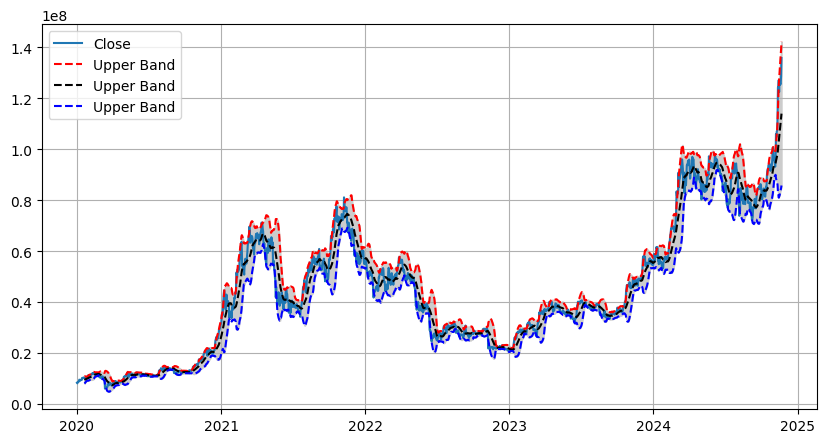

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Close'], label='Close')
plt.plot(df.index, df['upper_band'], 'r--' , label='Upper Band')
plt.plot(df.index, df['MA20'], 'k--' , label='Upper Band')
plt.plot(df.index, df['lower_band'], 'b--' , label='Upper Band')
plt.fill_between(df.index, df['upper_band'], df['lower_band'], color='0.8')
plt.legend(loc='best')
plt.grid()
plt.show()

### 주가의 볼린저 밴드 현재 위치 확인하기

<Axes: >

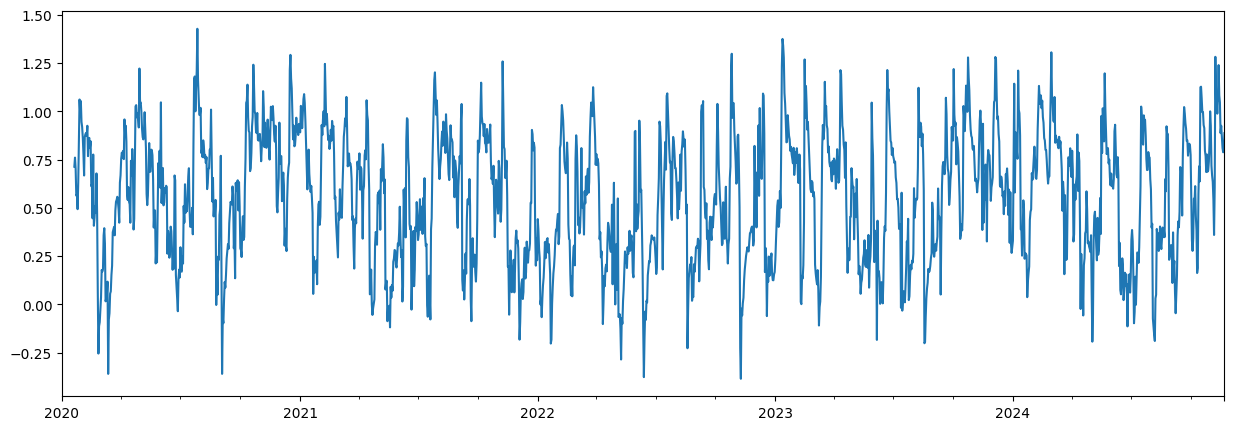

In [14]:
df['%b'] = (df['Close'] - df['lower_band']) / (df['upper_band'] - df['lower_band'])
df['%b'].plot(figsize=(15, 5))

<Axes: >

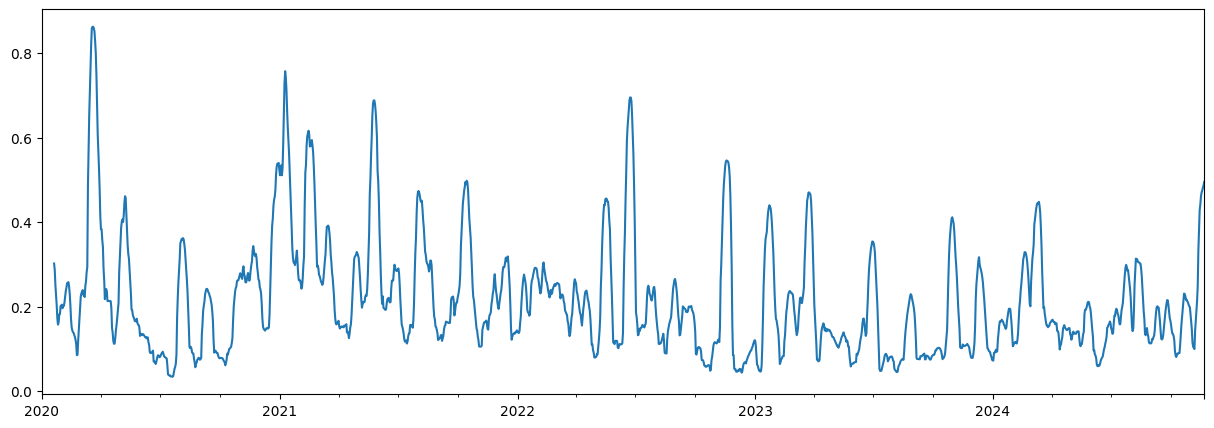

In [15]:
# bandwidth이 커진다 -> 변동성이 커진다.
# bandwidth이 반대로 향한다. -> 추세가 바뀐다.
df['bandwidth'] = (df['upper_band'] - df['lower_band']) / df['MA20']
df['bandwidth'].plot(figsize=(15, 5))

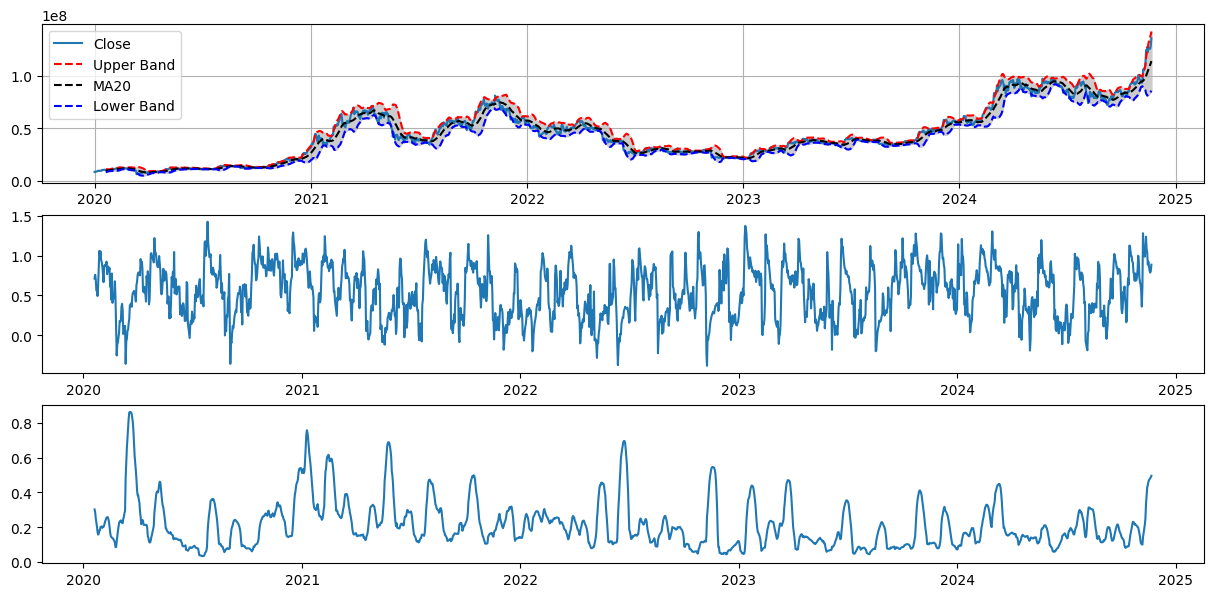

In [24]:
plt.figure(figsize=(15, 7))
plt.subplot(3,1,1)
plt.plot(df.index, df['Close'], label='Close')
plt.plot(df.index, df['upper_band'], 'r--' , label='Upper Band')
plt.plot(df.index, df['MA20'], 'k--' , label='MA20')
plt.plot(df.index, df['lower_band'], 'b--' , label='Lower Band')
plt.fill_between(df.index, df['upper_band'], df['lower_band'], color='0.8')
plt.legend(loc='best')
plt.grid()

plt.subplot(3,1,2)
plt.plot(df.index, df['%b'], label='%b')

plt.subplot(3,1,3)
plt.plot(df.index, df['bandwidth'], label='bandwidth')

plt.show()

### MFI를 활용한 추세추종 매매 -> 오른놈이 더 오를꺼야
- MF(money flow) = 거래량 X (고가 + 종가 + 저가)/3
- MFR = 양의 MF/음의 MF
- MFI = 100 -(100/(1 + MFR))
- (MFI > 80) -> 매수
- (MFI < 20) -> 매도

In [50]:
df_MFI = fdr.DataReader('035900', '2020')
df_MFI['MF'] = df_MFI['Volume'] * (df_MFI['High'] + df_MFI['Low'] + df_MFI['Close']) / 3
df_MFI['BUY_MF'] = df_MFI['MF'].where(df_MFI['Close'] > df_MFI['Open']).fillna(0)
df_MFI['SELL_MF'] = df_MFI['MF'].where(df_MFI['Close'] <= df_MFI['Open']).fillna(0)
df_MFI['MFR'] = df_MFI['BUY_MF'].rolling(window=14).sum() / df_MFI['SELL_MF'].rolling(window=14).sum()
df_MFI['MFI'] = 100 - (100 / (1 + df_MFI['MFR']))
df_MFI.tail()

,Open,High,Low,Close,Volume,Change,MF,BUY_MF,SELL_MF,MFR,MFI
Date,,,,,,,,,,,
2024-11-15,57400,59700,56200,59400,1380530,0.045775,8.066897e+10,8.066897e+10,0.000000e+00,1.178954,54.106423
2024-11-18,59800,60400,58100,59400,778075,0.000000,4.613985e+10,0.000000e+00,4.613985e+10,1.045552,51.113430
2024-11-19,60700,64500,60100,64000,2699562,0.077441,1.697125e+11,1.697125e+11,0.000000e+00,1.651057,62.279196
2024-11-20,64400,65500,63400,64800,1042087,0.012500,6.728408e+10,6.728408e+10,0.000000e+00,1.936135,65.941617
2024-11-21,64900,67000,63200,65500,1092885,0.010802,7.129253e+10,7.129253e+10,0.000000e+00,2.162529,68.379732


In [51]:
buy_date = df_MFI[df_MFI['MFI'] > 80].index
sell_date = df_MFI[df_MFI['MFI'] < 20].index

In [52]:
df_MFI['MA20'] = df_MFI['Close'].rolling(window=20).mean()
df_MFI['stddev'] = df_MFI['Close'].rolling(window=20).std()
df_MFI['upper_band'] = df_MFI['MA20'] + 2 * df_MFI['stddev']
df_MFI['lower_band'] = df_MFI['MA20'] - 2 * df_MFI['stddev']

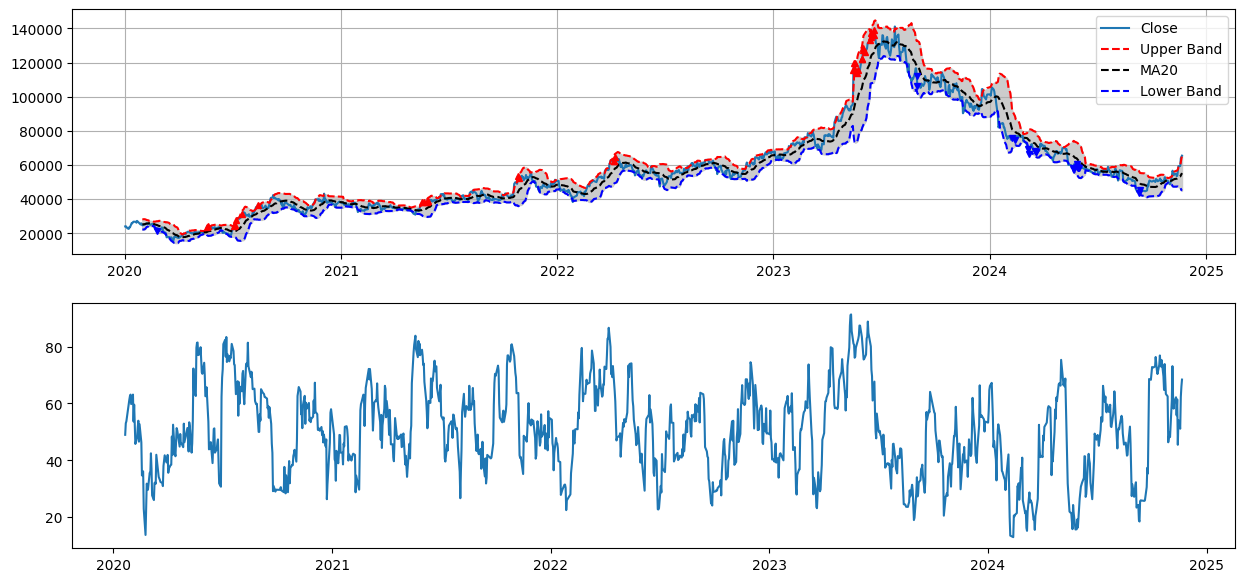

In [53]:
plt.figure(figsize=(15, 7))
plt.subplot(2,1,1)
plt.plot(df_MFI.index, df_MFI['Close'], label='Close')
plt.plot(df_MFI.index, df_MFI['upper_band'], 'r--' , label='Upper Band')
plt.plot(df_MFI.index, df_MFI['MA20'], 'k--' , label='MA20')
plt.plot(df_MFI.index, df_MFI['lower_band'], 'b--' , label='Lower Band')
plt.fill_between(df_MFI.index, df_MFI['upper_band'], df_MFI['lower_band'], color='0.8')
plt.plot(buy_date, df_MFI.loc[buy_date, 'Close'], '^', markersize = 4, color = 'r')
plt.plot(sell_date, df_MFI.loc[sell_date, 'Close'], 'v', markersize = 4, color = 'b')
plt.legend(loc='best')
plt.grid()

plt.subplot(2,1,2)
plt.plot(df_MFI.index, df_MFI['MFI'], label='MFI')

plt.show()

### 거래강도를 활용한 반전매매 -> 충분히 떨어졌으니까 이제 오를까
- Intraday Intensity Indicator(II ; 일중강도지수)
- 일중 강도(II) = {(2 * 종가 - 고가 - 저가) / (고가 - 저가)} *거래량
- 일중 강도율(IIR) = (21일 간의 일중 강도 합 / 21일간의 거래량 합) * 100
- 일중 강도율은 종가가 거래 범위 천정권에 가까우면 1, 중간이면 0, 바닥권에 가까우면 -1에 근접한 값을 나타낸다.

In [57]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

In [78]:
df_II = fdr.DataReader('035900', '2020')
df_II['II'] = ((2 * df_II['Close'] - df_II['High'] - df_II['Low']) / (df_II['High'] - df_II['Low'])) * df_II['Volume']
df_II['IIR'] = (df_II['II'].rolling(window=21).sum() / df_II['Volume'].rolling(window=21).sum()) * 100
df_II.tail()

,Open,High,Low,Close,Volume,Change,II,IIR
Date,,,,,,,,
2024-11-15,57400,59700,56200,59400,1380530,0.05,1143867.71,0.07
2024-11-18,59800,60400,58100,59400,778075,0.00,101488.04,0.09
2024-11-19,60700,64500,60100,64000,2699562,0.08,2086025.18,0.21
2024-11-20,64400,65500,63400,64800,1042087,0.01,347362.33,0.21
2024-11-21,64900,67000,63200,65500,1092885,0.01,230081.05,0.20


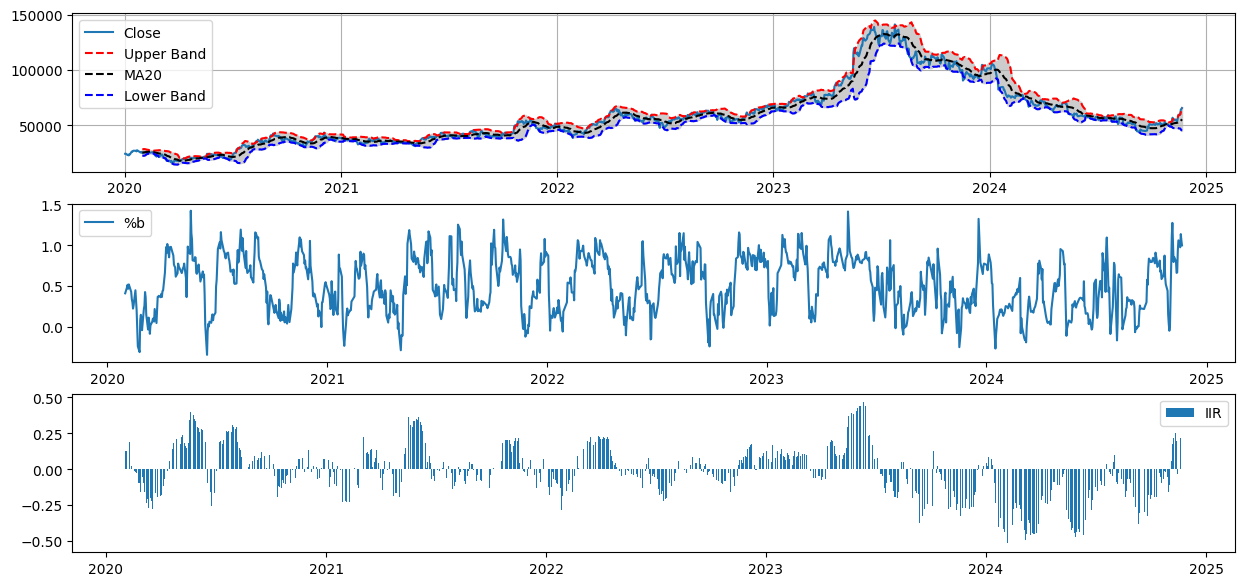

In [79]:
df_II['MA20'] = df_II['Close'].rolling(window=20).mean()
df_II['stddev'] = df_II['Close'].rolling(window=20).std()
df_II['upper_band'] = df_II['MA20'] + 2 * df_II['stddev']
df_II['lower_band'] = df_II['MA20'] - 2 * df_II['stddev']
df_II['%b'] = (df_II['Close'] - df_II['lower_band']) / (df_II['upper_band'] - df_II['lower_band'])

plt.figure(figsize=(15, 7))
plt.subplot(3,1,1)
plt.plot(df_II.index, df_II['Close'], label='Close')
plt.plot(df_II.index, df_II['upper_band'], 'r--' , label='Upper Band')
plt.plot(df_II.index, df_II['MA20'], 'k--' , label='MA20')
plt.plot(df_II.index, df_II['lower_band'], 'b--' , label='Lower Band')
plt.fill_between(df_II.index, df_II['upper_band'], df_II['lower_band'], color='0.8')
plt.legend(loc='best')
plt.grid()

plt.subplot(3,1,2)
plt.plot(df_II.index, df_II['%b'], label='%b')
plt.legend(loc='best')

plt.subplot(3,1,3)
plt.bar(df_II.index, df_II['IIR'], label='IIR')
plt.legend(loc='best')

plt.show()

- 볼린저 밴드가 하단에 닿는다 & IIR이 + -> 매수
- 볼린저 밴드가 상단에 닿는다 & IIR이 - -> 매도

In [75]:
buy_date = df_II[(df_II['%b'] < 0.30) & (df_II['IIR'] > 0)].index # 밴드 위치가 하단에 있으면서 거래 강도가 양의 방향
sell_date = df_II[(df_II['%b'] > 0.95) & (df_II['IIR'] < 0)].index # 밴드 위치가 상단에 있으면서 거래 강도가 음의 방향

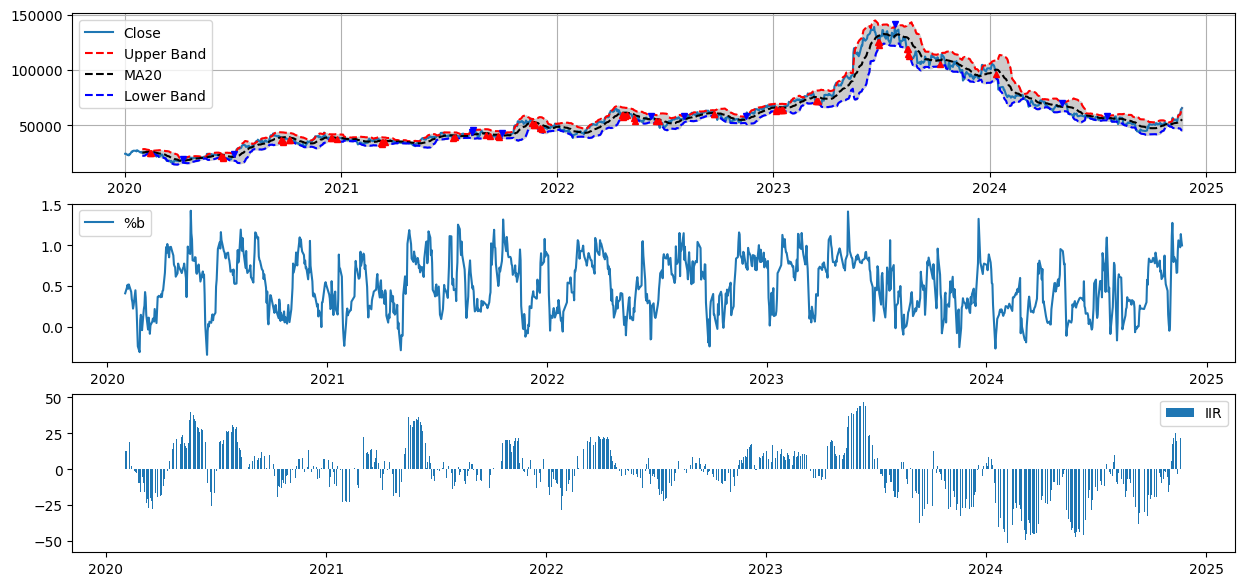

In [76]:
plt.figure(figsize=(15, 7))
plt.subplot(3,1,1)
plt.plot(df_II.index, df_II['Close'], label='Close')
plt.plot(df_II.index, df_II['upper_band'], 'r--' , label='Upper Band')
plt.plot(df_II.index, df_II['MA20'], 'k--' , label='MA20')
plt.plot(df_II.index, df_II['lower_band'], 'b--' , label='Lower Band')
plt.plot(buy_date, df_II.loc[buy_date, 'Close'], '^', markersize = 4, color = 'r')
plt.plot(sell_date, df_II.loc[sell_date, 'Close'], 'v', markersize = 4, color = 'b')
plt.fill_between(df_II.index, df_II['upper_band'], df_II['lower_band'], color='0.8')
plt.legend(loc='best')
plt.grid()

plt.subplot(3,1,2)
plt.plot(df_II.index, df_II['%b'], label='%b')
plt.legend(loc='best')

plt.subplot(3,1,3)
plt.bar(df_II.index, df_II['IIR'], label='IIR')
plt.legend(loc='best')

plt.show()